In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('whitegrid')
warnings.filterwarnings("ignore")
file_path = '/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz'

try:
    
    chunks = pd.read_csv(
        file_path, 
        compression='gzip', 
        chunksize=100000, 
        low_memory=False,
        parse_dates=['issue_d']
    )
    
    df_list = []
    for chunk in chunks:
        df_list.append(chunk.sample(frac=0.1, random_state=42)) # Sample 10% of each chunk
    
    df = pd.concat(df_list, ignore_index=True)
    
   
    if len(df) > 250000:
        df = df.sample(n=250000, random_state=42)

except Exception as e:
    print(f"Error loading data: {e}")
    print("Attempting to load with sampling on the full read (slower)...")
    df = pd.read_csv(
        file_path,
        compression='gzip', # Handle the gzipped file
        low_memory=False,
        parse_dates=['issue_d']
    ).sample(n=250000, random_state=42)


print(f"Data loaded with {len(df)} rows and {len(df.columns)} columns.")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

Data loaded with 226070 rows and 151 columns.


In [4]:

print("Original loan_status value counts:")
print(df['loan_status'].value_counts(normalize=True) * 100)
print("\n")


target_map = {
    'Fully Paid': 0,
    'Charged Off': 1
}


df_filtered = df[df['loan_status'].isin(target_map.keys())].copy()


df_filtered['target'] = df_filtered['loan_status'].map(target_map)

print(f"Filtered data to {len(df_filtered)} rows.")
print("\nNew 'target' variable distribution:")
print(df_filtered['target'].value_counts(normalize=True) * 100)

Original loan_status value counts:
loan_status
Fully Paid                                             47.729887
Current                                                38.836545
Charged Off                                            11.776103
Late (31-120 days)                                      0.947060
In Grace Period                                         0.393245
Late (16-30 days)                                       0.191535
Does not meet the credit policy. Status:Fully Paid      0.085815
Does not meet the credit policy. Status:Charged Off     0.037599
Default                                                 0.002212
Name: proportion, dtype: float64


Filtered data to 134524 rows.

New 'target' variable distribution:
target
0    80.210223
1    19.789777
Name: proportion, dtype: float64


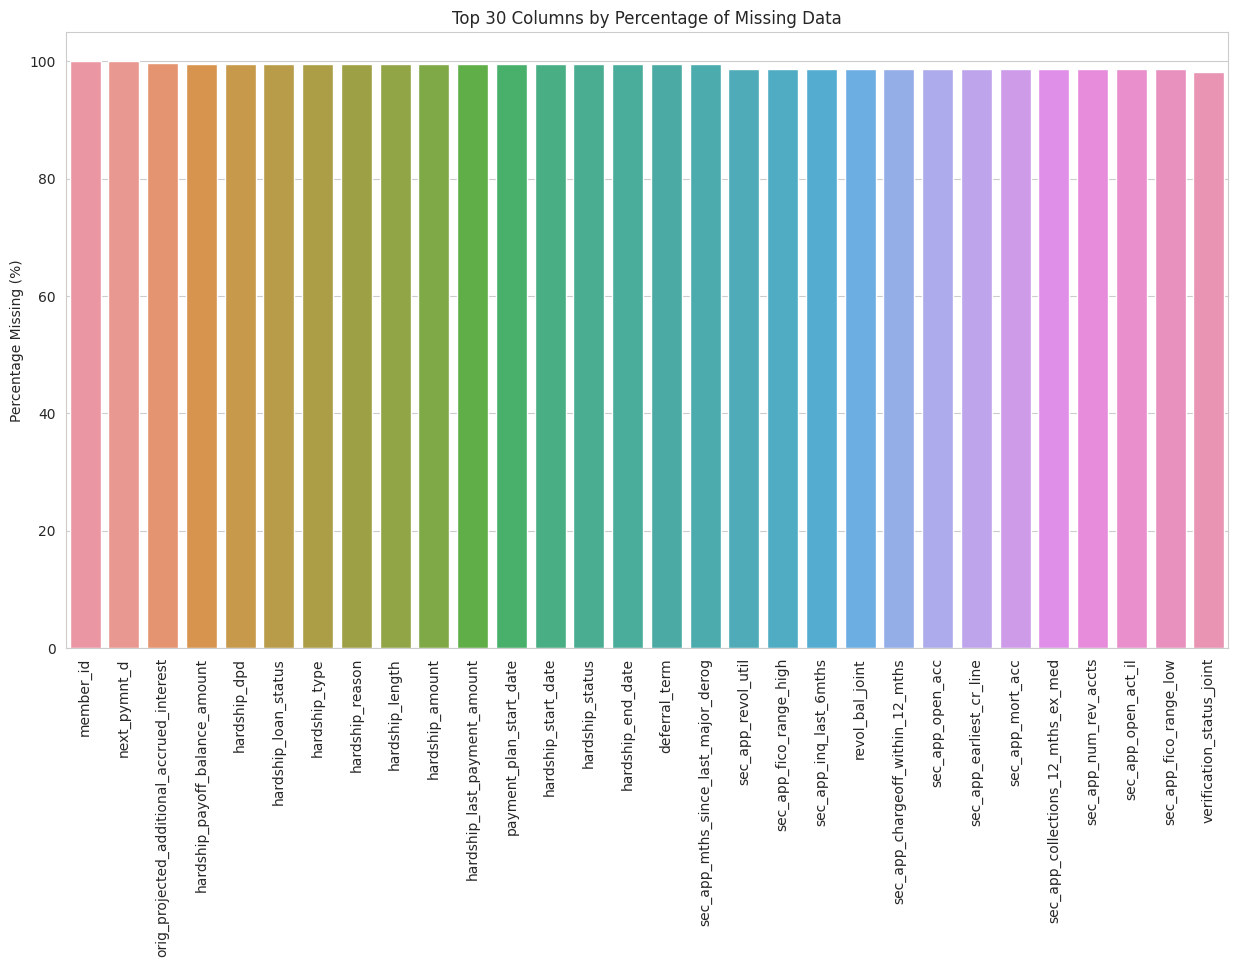

member_id                                     100.000000
next_pymnt_d                                  100.000000
orig_projected_additional_accrued_interest     99.709346
hardship_payoff_balance_amount                 99.553240
hardship_dpd                                   99.553240
hardship_loan_status                           99.553240
hardship_type                                  99.553240
hardship_reason                                99.553240
hardship_length                                99.553240
hardship_amount                                99.553240
hardship_last_payment_amount                   99.553240
payment_plan_start_date                        99.553240
hardship_start_date                            99.553240
hardship_status                                99.553240
hardship_end_date                              99.553240
deferral_term                                  99.553240
sec_app_mths_since_last_major_derog            99.506408
sec_app_revol_util             

In [5]:

missing_data = (df_filtered.isnull().sum() / len(df_filtered)) * 100
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)


plt.figure(figsize=(15, 8))
sns.barplot(x=missing_data.head(30).index, y=missing_data.head(30).values)
plt.title('Top 30 Columns by Percentage of Missing Data')
plt.ylabel('Percentage Missing (%)')
plt.xticks(rotation=90)
plt.show()


print(missing_data.head(50))

missing_threshold = 40
cols_to_drop_missing = missing_data[missing_data > missing_threshold].index.tolist()

df_cleaned = df_filtered.drop(columns=cols_to_drop_missing)

print(f"\nDropped {len(cols_to_drop_missing)} columns due to >{missing_threshold}% missing data.")
print(f"Remaining columns: {len(df_cleaned.columns)}")

In [6]:

print("Remaining columns:", df_cleaned.columns.tolist())

cols_to_drop_irrelevant = ['id', 'emp_title', 'url', 'zip_code', 'title']

cols_to_drop_leakage = [
    'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 
    'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 
    'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 
    'last_fico_range_low'
]

cols_to_drop_unique = []
for col in df_cleaned.columns:
    if col not in cols_to_drop_irrelevant + cols_to_drop_leakage:
        if df_cleaned[col].nunique() == 1:
            cols_to_drop_unique.append(col)
            
print(f"\nFound {len(cols_to_drop_unique)} columns with only one unique value: {cols_to_drop_unique}")

total_cols_to_drop = list(set(cols_to_drop_irrelevant + cols_to_drop_leakage + cols_to_drop_unique))


total_cols_to_drop = [col for col in total_cols_to_drop if col not in ['target', 'loan_status']]


df_preprocessed = df_cleaned.drop(columns=total_cols_to_drop)

print(f"\nDropped {len(total_cols_to_drop)} irrelevant/leaky/unique-value columns.")
print(f"We now have {len(df_preprocessed.columns)} columns left for analysis.")

Remaining columns: ['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 


Found 56 numerical features.
Found 14 categorical features.

 Categorical Feature Analysis
Column 'term': 2 unique values
Column 'grade': 7 unique values
Column 'sub_grade': 35 unique values
Column 'emp_length': 11 unique values
Column 'home_ownership': 6 unique values
Column 'verification_status': 3 unique values
Column 'loan_status': 2 unique values
Column 'purpose': 14 unique values
Column 'addr_state': 50 unique values
Column 'earliest_cr_line': 658 unique values
Column 'initial_list_status': 2 unique values
Column 'application_type': 2 unique values
Column 'disbursement_method': 2 unique values
Column 'debt_settlement_flag': 2 unique values
Numerical Feature Analysis
Top 10 Numerical Features Correlated with Target (Default=1):
target                  1.000000
int_rate                0.255450
fico_range_low          0.133172
fico_range_high         0.133170
acc_open_past_24mths    0.096801
bc_open_to_buy          0.082377
num_tl_op_past_12m      0.080641
tot_hi_cred_lim         0

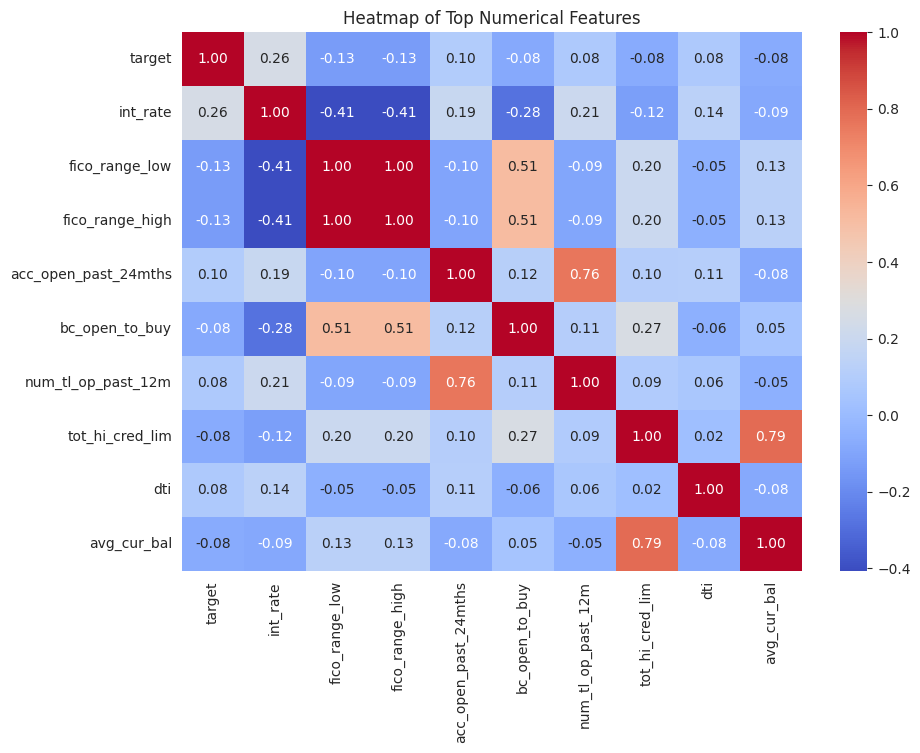

In [7]:

numerical_features = df_preprocessed.select_dtypes(include=np.number).columns.tolist()
categorical_features = df_preprocessed.select_dtypes(include='object').columns.tolist()


if 'target' in numerical_features:
    numerical_features.remove('target')

print(f"\nFound {len(numerical_features)} numerical features.")
print(f"Found {len(categorical_features)} categorical features.")


print("\n Categorical Feature Analysis")

for col in categorical_features:
    print(f"Column '{col}': {df_preprocessed[col].nunique()} unique values")
    


print("Numerical Feature Analysis")

corr_matrix = df_preprocessed[numerical_features + ['target']].corr()
target_corr = corr_matrix['target'].abs().sort_values(ascending=False)

print("Top 10 Numerical Features Correlated with Target (Default=1):")
print(target_corr.head(10))


top_corr_features = target_corr.head(10).index
plt.figure(figsize=(10, 7))
sns.heatmap(
    df_preprocessed[top_corr_features].corr(), 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm'
)
plt.title('Heatmap of Top Numerical Features')
plt.show()

In [8]:
selected_numerical_features = [
    'loan_amnt',
    'int_rate',
    'installment',
    'annual_inc',
    'dti',
    'fico_range_low',
    'open_acc',
    'pub_rec',
    'revol_bal',
    'revol_util',
    'total_acc',
    'mort_acc',
    'pub_rec_bankruptcies'
]

selected_categorical_features = [
    'term',
    'grade',
    'sub_grade',
    'emp_length',
    'home_ownership',
    'verification_status',
    'purpose',
    'addr_state'
]

final_features = selected_numerical_features + selected_categorical_features
df_final = df_preprocessed[final_features + ['target']].copy()
loan_amounts = df_final['loan_amnt'].values
interest_rates = df_final['int_rate'].values / 100.0
y = df_final['target'].astype(int).values
X_features_df = df_final[final_features].copy()

print(f"Selected {len(final_features)} features for the models.")
print("\nMissing values in *selected* features:")
print(X_features_df.isnull().sum()[X_features_df.isnull().sum() > 0])

for col in selected_numerical_features:
    if X_features_df[col].isnull().sum() > 0:
        median_val = X_features_df[col].median()
        X_features_df[col] = X_features_df[col].fillna(median_val)
        print(f"Filled NA in '{col}' with median: {median_val}")

for col in selected_categorical_features:
    if X_features_df[col].isnull().sum() > 0:
        X_features_df[col] = X_features_df[col].fillna('Missing')
        print(f"Filled NA in '{col}' with new 'Missing' category")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, selected_numerical_features),
        ('cat', categorical_transformer, selected_categorical_features)
    ],
    remainder='drop'
)

X = preprocessor.fit_transform(X_features_df)

try:
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(selected_categorical_features)
except AttributeError:
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out()

all_feature_names = selected_numerical_features + list(cat_feature_names)

print(f"\nPreprocessing complete.")
print(f"Feature matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")
print(f"Loan amounts shape: {loan_amounts.shape}")
print(f"Interest rates shape: {interest_rates.shape}")
print(f"Total features after OHE: {X.shape[1]}")
print(f"First 5 processed feature names: {all_feature_names[:5]}")
print(f"Last 5 processed feature names: {all_feature_names[-5:]}")


Selected 21 features for the models.

Missing values in *selected* features:
dti                       39
revol_util               100
mort_acc                4744
pub_rec_bankruptcies      65
emp_length              7783
dtype: int64
Filled NA in 'dti' with median: 17.57
Filled NA in 'revol_util' with median: 52.1
Filled NA in 'mort_acc' with median: 1.0
Filled NA in 'pub_rec_bankruptcies' with median: 0.0
Filled NA in 'emp_length' with new 'Missing' category

Preprocessing complete.
Feature matrix X shape: (134524, 142)
Target vector y shape: (134524,)
Loan amounts shape: (134524,)
Interest rates shape: (134524,)
Total features after OHE: 142
First 5 processed feature names: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti']
Last 5 processed feature names: ['addr_state_VT', 'addr_state_WA', 'addr_state_WI', 'addr_state_WV', 'addr_state_WY']


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (107619, 142)
X_test shape: (26905, 142)
y_train shape: (107619,)
y_test shape: (26905,)


In [10]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).float().view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test).float().to(device)
y_test_tensor = torch.tensor(y_test).float().view(-1, 1).to(device)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


BATCH_SIZE = 1024
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("PyTorch DataLoaders created.")

Using device: cuda
PyTorch DataLoaders created.


In [11]:
class DefaultPredictorMLP(nn.Module):
    def __init__(self, input_features):
        super(DefaultPredictorMLP, self).__init__()
        self.layer_1 = nn.Linear(input_features, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3) # Dropout for regularization
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x)) 
        return x


input_features = X.shape[1] # This is 142
model_dl = DefaultPredictorMLP(input_features).to(device)
print(model_dl)

DefaultPredictorMLP(
  (layer_1): Linear(in_features=142, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)


In [12]:

criterion = nn.BCELoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.001)

NUM_EPOCHS = 10

model_dl.train() 
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    for i, (features, labels) in enumerate(train_loader):
        
        outputs = model_dl(features)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        
        
        optimizer.zero_grad() 
        loss.backward()       
        optimizer.step()     
        
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss/len(train_loader):.4f}")

print("Training complete.")

Epoch [1/10], Loss: 0.4916
Epoch [2/10], Loss: 0.4556
Epoch [3/10], Loss: 0.4527
Epoch [4/10], Loss: 0.4523
Epoch [5/10], Loss: 0.4515
Epoch [6/10], Loss: 0.4509
Epoch [7/10], Loss: 0.4486
Epoch [8/10], Loss: 0.4475
Epoch [9/10], Loss: 0.4463
Epoch [10/10], Loss: 0.4475
Training complete.


In [14]:

model_dl.eval() 

all_preds = []
all_labels = []

with torch.no_grad(): 
    for features, labels in test_loader:
        outputs = model_dl(features)
        
        
        all_preds.extend(outputs.cpu().numpy())
        
        all_labels.extend(labels.cpu().numpy())


y_pred_probs = np.array(all_preds)
y_true = np.array(all_labels)


y_pred_binary = (y_pred_probs > 0.5).astype(int)


auc_score = roc_auc_score(y_true, y_pred_probs)
f1 = f1_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
cm = confusion_matrix(y_true, y_pred_binary)


print(f"AUC (Area Under the ROC Curve): {auc_score:.4f}")
print(f"F1-Score:                       {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print(cm)

AUC (Area Under the ROC Curve): 0.7078
F1-Score:                       0.1727
Precision: 0.5169
Recall:    0.1037
[[21065   516]
 [ 4772   552]]


In [15]:
from sklearn.metrics import precision_recall_curve


precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)


f1_scores = (2 * precision * recall) / (precision + recall + 1e-10)


best_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_index]
best_f1 = f1_scores[best_f1_index]

print(f"\n Default 0.5 Threshold F1-Score: {f1:.4f}")
print(f"Optimal Threshold for F1: {best_threshold:.4f}")
print(f"Best F1-Score at new threshold: {best_f1:.4f}")


y_pred_binary_best = (y_pred_probs > best_threshold).astype(int)

auc_score = roc_auc_score(y_true, y_pred_probs) # AUC doesn't change
f1_best = f1_score(y_true, y_pred_binary_best)
precision_best = precision_score(y_true, y_pred_binary_best)
recall_best = recall_score(y_true, y_pred_binary_best)
cm_best = confusion_matrix(y_true, y_pred_binary_best)

print("\n Task 2: Evaluation with *Optimal F1 Threshold* ")
print(f"AUC (Area Under the ROC Curve): {auc_score:.4f}")
print(f"F1-Score:                       {f1_best:.4f}")

print(f"Precision: {precision_best:.4f}")
print(f"Recall:    {recall_best:.4f}")
print("\n Confusion Matrix:")
print(cm_best)


 Default 0.5 Threshold F1-Score: 0.1727
Optimal Threshold for F1: 0.2174
Best F1-Score at new threshold: 0.4249

 Task 2: Evaluation with *Optimal F1 Threshold* 
AUC (Area Under the ROC Curve): 0.7078
F1-Score:                       0.4248
Precision: 0.3276
Recall:    0.6041

 Confusion Matrix:
[[14979  6602]
 [ 2108  3216]]


In [16]:
!pip install d3rlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 13.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.9 MB/s eta 0:00:00:

In [17]:
profit = loan_amounts * interest_rates

loss = -loan_amounts

rewards = np.where(y == 1, loss, profit)

print(f"Engineered rewards vector with shape: {rewards.shape}")
print(f"Example 'Fully Paid' reward (profit): {rewards[y == 0][0]:.2f}")
print(f"Example 'Defaulted' reward (loss):    {rewards[y == 1][0]:.2f}")
print(f"Average reward in our dataset: {np.mean(rewards):.2f}")

Engineered rewards vector with shape: (134524,)
Example 'Fully Paid' reward (profit): 924.60
Example 'Defaulted' reward (loss):    -3000.00
Average reward in our dataset: -1596.53


In [18]:
import d3rlpy
from d3rlpy.dataset import MDPDataset


observations = X.astype('float32')


actions = np.ones(len(X), dtype='int32') 


rewards = rewards.astype('float32')


terminals = np.ones(len(X), dtype='float32')

dataset = MDPDataset(
    observations=observations,
    actions=actions,
    rewards=rewards,
    terminals=terminals
)

print("d3rlpy MDPDataset created.")

2025-10-29 19:37.19 [info     ] Register Shimmy environments. 
2025-10-29 19:37.20 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(142,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-10-29 19:37.20 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-10-29 19:37.20 [info     ] Action size has been automatically determined. action_size=2
d3rlpy MDPDataset created.


In [19]:
from sklearn.model_selection import train_test_split
from d3rlpy.algos import DiscreteCQLConfig  
from d3rlpy.dataset import MDPDataset 


(
    obs_train, 
    obs_test,
    act_train,
    act_test,
    rew_train,
    rew_test,
    term_train,
    term_test
) = train_test_split(
    observations,  
    actions,      
    rewards,       
    terminals,     
    test_size=0.2,
    random_state=42
)


train_dataset = MDPDataset(
    observations=obs_train,
    actions=act_train,
    rewards=rew_train,
    terminals=term_train
)

test_dataset = MDPDataset(
    observations=obs_test,
    actions=act_test,
    rewards=rew_test,
    terminals=term_test
)

print(f"Dataset split complete. Train size: {len(obs_train)}, Test size: {len(obs_test)}")


cql = DiscreteCQLConfig().create(device=device.type)


print("Starting RL agent training...")
cql.fit(
    train_dataset,
    n_steps=10000,
    n_steps_per_epoch=1000
)

print("RL Agent training complete.")

2025-10-29 19:37.21 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(142,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-10-29 19:37.21 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-10-29 19:37.22 [info     ] Action size has been automatically determined. action_size=2
2025-10-29 19:37.22 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(142,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-10-29 19:37.22 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-10-29 19:37.22 [info     ] Action size has been automatically determined. action_size=2
Datase

Epoch 1/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:37.28 [info     ] DiscreteCQL_20251029193722: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0008408441543579101, 'time_algorithm_update': 0.00500073504447937, 'loss': 4424.223663696289, 'td_loss': 4424.175489013672, 'conservative_loss': 0.04817492142319679, 'time_step': 0.005906943082809448} step=1000
2025-10-29 19:37.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029193722/model_1000.d3


Epoch 2/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:37.33 [info     ] DiscreteCQL_20251029193722: epoch=2 step=2000 epoch=2 metrics={'time_sample_batch': 0.0007853505611419677, 'time_algorithm_update': 0.0044098422527313235, 'loss': 4114.095864379883, 'td_loss': 4114.095864379883, 'conservative_loss': 0.0, 'time_step': 0.005250159740447998} step=2000
2025-10-29 19:37.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029193722/model_2000.d3


Epoch 3/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:37.39 [info     ] DiscreteCQL_20251029193722: epoch=3 step=3000 epoch=3 metrics={'time_sample_batch': 0.0007915217876434326, 'time_algorithm_update': 0.004457618474960327, 'loss': 3948.419189025879, 'td_loss': 3948.419189025879, 'conservative_loss': 0.0, 'time_step': 0.0053068468570709225} step=3000
2025-10-29 19:37.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029193722/model_3000.d3


Epoch 4/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:37.44 [info     ] DiscreteCQL_20251029193722: epoch=4 step=4000 epoch=4 metrics={'time_sample_batch': 0.0007815008163452148, 'time_algorithm_update': 0.00443810248374939, 'loss': 3740.2176526794433, 'td_loss': 3740.2176526794433, 'conservative_loss': 0.0, 'time_step': 0.005273161888122558} step=4000
2025-10-29 19:37.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029193722/model_4000.d3


Epoch 5/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:37.50 [info     ] DiscreteCQL_20251029193722: epoch=5 step=5000 epoch=5 metrics={'time_sample_batch': 0.0008335087299346924, 'time_algorithm_update': 0.004720017671585083, 'loss': 3703.8694904174804, 'td_loss': 3703.8694904174804, 'conservative_loss': 0.0, 'time_step': 0.005613476037979126} step=5000
2025-10-29 19:37.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029193722/model_5000.d3


Epoch 6/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:37.55 [info     ] DiscreteCQL_20251029193722: epoch=6 step=6000 epoch=6 metrics={'time_sample_batch': 0.000799757719039917, 'time_algorithm_update': 0.0044715597629547115, 'loss': 3714.216870849609, 'td_loss': 3714.216870849609, 'conservative_loss': 0.0, 'time_step': 0.005328685760498047} step=6000
2025-10-29 19:37.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029193722/model_6000.d3


Epoch 7/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:38.00 [info     ] DiscreteCQL_20251029193722: epoch=7 step=7000 epoch=7 metrics={'time_sample_batch': 0.0008092179298400879, 'time_algorithm_update': 0.004422321081161499, 'loss': 3705.4079053649903, 'td_loss': 3705.4079053649903, 'conservative_loss': 0.0, 'time_step': 0.005288475275039673} step=7000
2025-10-29 19:38.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029193722/model_7000.d3


Epoch 8/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:38.06 [info     ] DiscreteCQL_20251029193722: epoch=8 step=8000 epoch=8 metrics={'time_sample_batch': 0.0007939448356628418, 'time_algorithm_update': 0.004426951885223389, 'loss': 3637.709459197998, 'td_loss': 3637.709459197998, 'conservative_loss': 0.0, 'time_step': 0.005277606964111328} step=8000
2025-10-29 19:38.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029193722/model_8000.d3


Epoch 9/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:38.11 [info     ] DiscreteCQL_20251029193722: epoch=9 step=9000 epoch=9 metrics={'time_sample_batch': 0.0007926630973815918, 'time_algorithm_update': 0.004420659303665161, 'loss': 3587.1492575073244, 'td_loss': 3587.1492575073244, 'conservative_loss': 0.0, 'time_step': 0.005269755125045777} step=9000
2025-10-29 19:38.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029193722/model_9000.d3


Epoch 10/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:38.16 [info     ] DiscreteCQL_20251029193722: epoch=10 step=10000 epoch=10 metrics={'time_sample_batch': 0.0007926392555236817, 'time_algorithm_update': 0.004404665231704712, 'loss': 3627.4595323791505, 'td_loss': 3627.4595323791505, 'conservative_loss': 0.0, 'time_step': 0.00525259280204773} step=10000
2025-10-29 19:38.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029193722/model_10000.d3
RL Agent training complete.


In [20]:
from d3rlpy.ope import DiscreteFQE, FQEConfig
from d3rlpy.metrics import InitialStateValueEstimationEvaluator


isve_scorer = InitialStateValueEstimationEvaluator()


fqe = DiscreteFQE(
    algo=cql,                
    config=FQEConfig(),      
    device=device.type
)


print("Starting FQE (policy evaluation) training...")
logs = fqe.fit(
    test_dataset,
    n_steps=10000,
    n_steps_per_epoch=1000,
    evaluators={"isve": isve_scorer}
)

final_epoch_log = logs[-1][1] 
estimated_value = final_epoch_log['isve'] 

print("\nTask 3: Offline RL Agent Evaluation")
print(f"Estimated Policy Value (per loan): {estimated_value:.4f}")


Starting FQE (policy evaluation) training...
2025-10-29 19:38.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(142,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-10-29 19:38.16 [debug    ] Building models...            
2025-10-29 19:38.16 [debug    ] Models have been built.       
2025-10-29 19:38.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20251029193816
2025-10-29 19:38.16 [info     ] Parameters                     params={'observation_shape': [142], 'action_size': 2, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'learning_rate': 0

Epoch 1/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:38.48 [info     ] DiscreteFQE_20251029193816: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0019933249950408937, 'time_algorithm_update': 0.003318289756774902, 'loss': 4374.055527099609, 'time_step': 0.005356036424636841, 'isve': 1057.2001953125} step=1000
2025-10-29 19:38.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251029193816/model_1000.d3


Epoch 2/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:39.19 [info     ] DiscreteFQE_20251029193816: epoch=2 step=2000 epoch=2 metrics={'time_sample_batch': 0.001969733715057373, 'time_algorithm_update': 0.0033537983894348145, 'loss': 3880.78691809082, 'time_step': 0.005367431640625, 'isve': 1624.3990478515625} step=2000
2025-10-29 19:39.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251029193816/model_2000.d3


Epoch 3/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:39.50 [info     ] DiscreteFQE_20251029193816: epoch=3 step=3000 epoch=3 metrics={'time_sample_batch': 0.0019813244342803955, 'time_algorithm_update': 0.003339877128601074, 'loss': 3743.4796219482423, 'time_step': 0.005364782571792602, 'isve': 1745.24853515625} step=3000
2025-10-29 19:39.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251029193816/model_3000.d3


Epoch 4/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:40.22 [info     ] DiscreteFQE_20251029193816: epoch=4 step=4000 epoch=4 metrics={'time_sample_batch': 0.002004993438720703, 'time_algorithm_update': 0.003352811574935913, 'loss': 3691.140920166016, 'time_step': 0.005403343677520752, 'isve': 1797.494873046875} step=4000
2025-10-29 19:40.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251029193816/model_4000.d3


Epoch 5/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:40.53 [info     ] DiscreteFQE_20251029193816: epoch=5 step=5000 epoch=5 metrics={'time_sample_batch': 0.0019882988929748537, 'time_algorithm_update': 0.0033470802307128907, 'loss': 3676.74816003418, 'time_step': 0.005379226446151734, 'isve': 1822.716552734375} step=5000
2025-10-29 19:40.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251029193816/model_5000.d3


Epoch 6/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:41.24 [info     ] DiscreteFQE_20251029193816: epoch=6 step=6000 epoch=6 metrics={'time_sample_batch': 0.001995814561843872, 'time_algorithm_update': 0.00331902813911438, 'loss': 3630.852260131836, 'time_step': 0.005359190940856934, 'isve': 1836.203857421875} step=6000
2025-10-29 19:41.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251029193816/model_6000.d3


Epoch 7/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:41.55 [info     ] DiscreteFQE_20251029193816: epoch=7 step=7000 epoch=7 metrics={'time_sample_batch': 0.0019960520267486574, 'time_algorithm_update': 0.003333466053009033, 'loss': 3656.487694213867, 'time_step': 0.005373531818389892, 'isve': 1856.447509765625} step=7000
2025-10-29 19:41.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251029193816/model_7000.d3


Epoch 8/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:42.27 [info     ] DiscreteFQE_20251029193816: epoch=8 step=8000 epoch=8 metrics={'time_sample_batch': 0.0019798829555511474, 'time_algorithm_update': 0.0033096096515655518, 'loss': 3592.7580809326173, 'time_step': 0.005333610534667969, 'isve': 1875.5462646484375} step=8000
2025-10-29 19:42.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251029193816/model_8000.d3


Epoch 9/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:42.58 [info     ] DiscreteFQE_20251029193816: epoch=9 step=9000 epoch=9 metrics={'time_sample_batch': 0.0020022261142730712, 'time_algorithm_update': 0.0033516850471496584, 'loss': 3602.775633239746, 'time_step': 0.005397430896759033, 'isve': 1889.7772216796875} step=9000
2025-10-29 19:42.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251029193816/model_9000.d3


Epoch 10/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-10-29 19:43.29 [info     ] DiscreteFQE_20251029193816: epoch=10 step=10000 epoch=10 metrics={'time_sample_batch': 0.0019905412197113036, 'time_algorithm_update': 0.003327341079711914, 'loss': 3574.576295410156, 'time_step': 0.00536193585395813, 'isve': 1893.2857666015625} step=10000
2025-10-29 19:43.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251029193816/model_10000.d3

Task 3: Offline RL Agent Evaluation
Estimated Policy Value (per loan): 1893.2858


In [21]:


print("Getting RL agent predictions...")
rl_actions = cql.predict(obs_test)

print("Getting DL model predictions...")
X_test_tensor = torch.tensor(X_test).float().to(device)

model_dl.to(device)
model_dl.eval()
with torch.no_grad():
    dl_probs = model_dl(X_test_tensor).cpu().numpy().flatten()

optimal_threshold = 0.2442 
dl_actions = (dl_probs < optimal_threshold).astype(int)

comparison_df = pd.DataFrame({
    'True_Target': y_test,
    'Historical_Reward': rew_test,
    'DL_Prob_Default': dl_probs,
    'DL_Action': dl_actions,
    'RL_Action': rl_actions
})

print("\n--- Task 4: Policy Comparison ---")
print(comparison_df.head())

print("\nApproval Rates:")
print(f"DL Model Approval Rate: {comparison_df['DL_Action'].mean():.2%}")
print(f"RL Model Approval Rate: {comparison_df['RL_Action'].mean():.2%}")

disagreements = comparison_df[comparison_df['DL_Action'] != comparison_df['RL_Action']]
print(f"\nTotal Disagreements: {len(disagreements)} out of {len(comparison_df)} ({len(disagreements)/len(comparison_df):.1%})")

rl_approves_dl_denies = disagreements[disagreements['RL_Action'] == 1]
print(f"\nCase 1: RL Approves, DL Denies: {len(rl_approves_dl_denies)}")

rl_denies_dl_approves = disagreements[disagreements['RL_Action'] == 0]
print(f"\nCase 2: RL Denies, DL Approves: {len(rl_denies_dl_approves)}")


Getting RL agent predictions...
Getting DL model predictions...

--- Task 4: Policy Comparison ---
   True_Target  Historical_Reward  DL_Prob_Default  DL_Action  RL_Action
0            0        5684.000000         0.214123          1          1
1            0      -40000.000000         0.096679          1          1
2            0       -7150.000000         0.629412          0          1
3            0      -11000.000000         0.461524          0          1
4            1         419.700012         0.130825          1          1

Approval Rates:
DL Model Approval Rate: 69.56%
RL Model Approval Rate: 100.00%

Total Disagreements: 8190 out of 26905 (30.4%)

Case 1: RL Approves, DL Denies: 8190

Case 2: RL Denies, DL Approves: 0


In [22]:
comparison_df['DL_Policy_Reward'] = comparison_df.apply(
    lambda row: row['Historical_Reward'] if row['DL_Action'] == 1 else 0.0, 
    axis=1
)

comparison_df['RL_Policy_Reward'] = comparison_df.apply(
    lambda row: row['Historical_Reward'] if row['RL_Action'] == 1 else 0.0, 
    axis=1
)

dl_avg_return = comparison_df['DL_Policy_Reward'].mean()
rl_avg_return = comparison_df['RL_Policy_Reward'].mean()

print("\n Task 4: Final Policy Value Simulation")
print(f"DL Model (F1-Optimized) Avg. Return: ${dl_avg_return:.2f} per loan")
print(f"RL Model (Naïve 100% Approve) Avg. Return: ${rl_avg_return:.2f} per loan")


 Task 4: Final Policy Value Simulation
DL Model (F1-Optimized) Avg. Return: $-1117.55 per loan
RL Model (Naïve 100% Approve) Avg. Return: $-1610.33 per loan
